In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
data_train=pd.read_csv("/kaggle/input/titanic/train.csv")
data_valid=pd.read_csv("/kaggle/input/titanic/test.csv")

# Data Analysis and Preprocessing

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
s=data_train.dtypes=='object'
cols=s[s].index
good_cols=[col for col in cols if
           set(data_train[col]).issubset(set(data_valid[col]))]
bad_cols=list(set(cols)-set(good_cols))
bad_cols,good_cols

(['Ticket', 'Name', 'Embarked', 'Cabin'], ['Sex'])

The bad columns for ordinal and one hot encoding are **'Name', 'Ticket', 'Cabin'** , it is better to drop them as they don't contribute much to the model but only create problems while encoding, the same can be verified by the below cell

In [6]:
s1=set(data_train['Cabin'].unique())
s2=set(data_valid["Cabin"].unique())
s1.issuperset(s2)
bad_cols.remove("Embarked")
good_cols.append("Embarked")

In [7]:
data_train.drop(bad_cols,axis=1,inplace=True)
data_valid.drop(bad_cols,axis=1,inplace=True)

In [8]:
from sklearn.preprocessing import OrdinalEncoder
enc=OrdinalEncoder()
data_train[good_cols]=enc.fit_transform(data_train[good_cols])
data_valid[good_cols]=enc.transform(data_valid[good_cols])

In [9]:
data_train.drop(['PassengerId'],axis=1,inplace=True)
data_valid_copy=data_valid.drop(['PassengerId'],axis=1)
data_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1.0,22.0,1,0,7.2500,2.0
1,1,1,0.0,38.0,1,0,71.2833,0.0
2,1,3,0.0,26.0,0,0,7.9250,2.0
3,1,1,0.0,35.0,1,0,53.1000,2.0
4,0,3,1.0,35.0,0,0,8.0500,2.0


# Data correlation

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.169718
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500,0.164681
Sex,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333,0.110320
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.032565
SibSp,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651,0.068900
Parch,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225,0.040449
Fare,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000,-0.226311
Embarked,-0.169718,0.164681,0.110320,-0.032565,0.068900,0.040449,-0.226311,1.000000


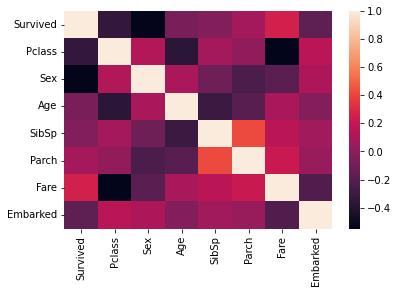

In [10]:
import seaborn as sns
cor=data_train.corr()
sns.heatmap(cor)
cor

array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Sex'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>,
        <AxesSubplot:title={'center':'Embarked'}>, <AxesSubplot:>]],
      dtype=object)

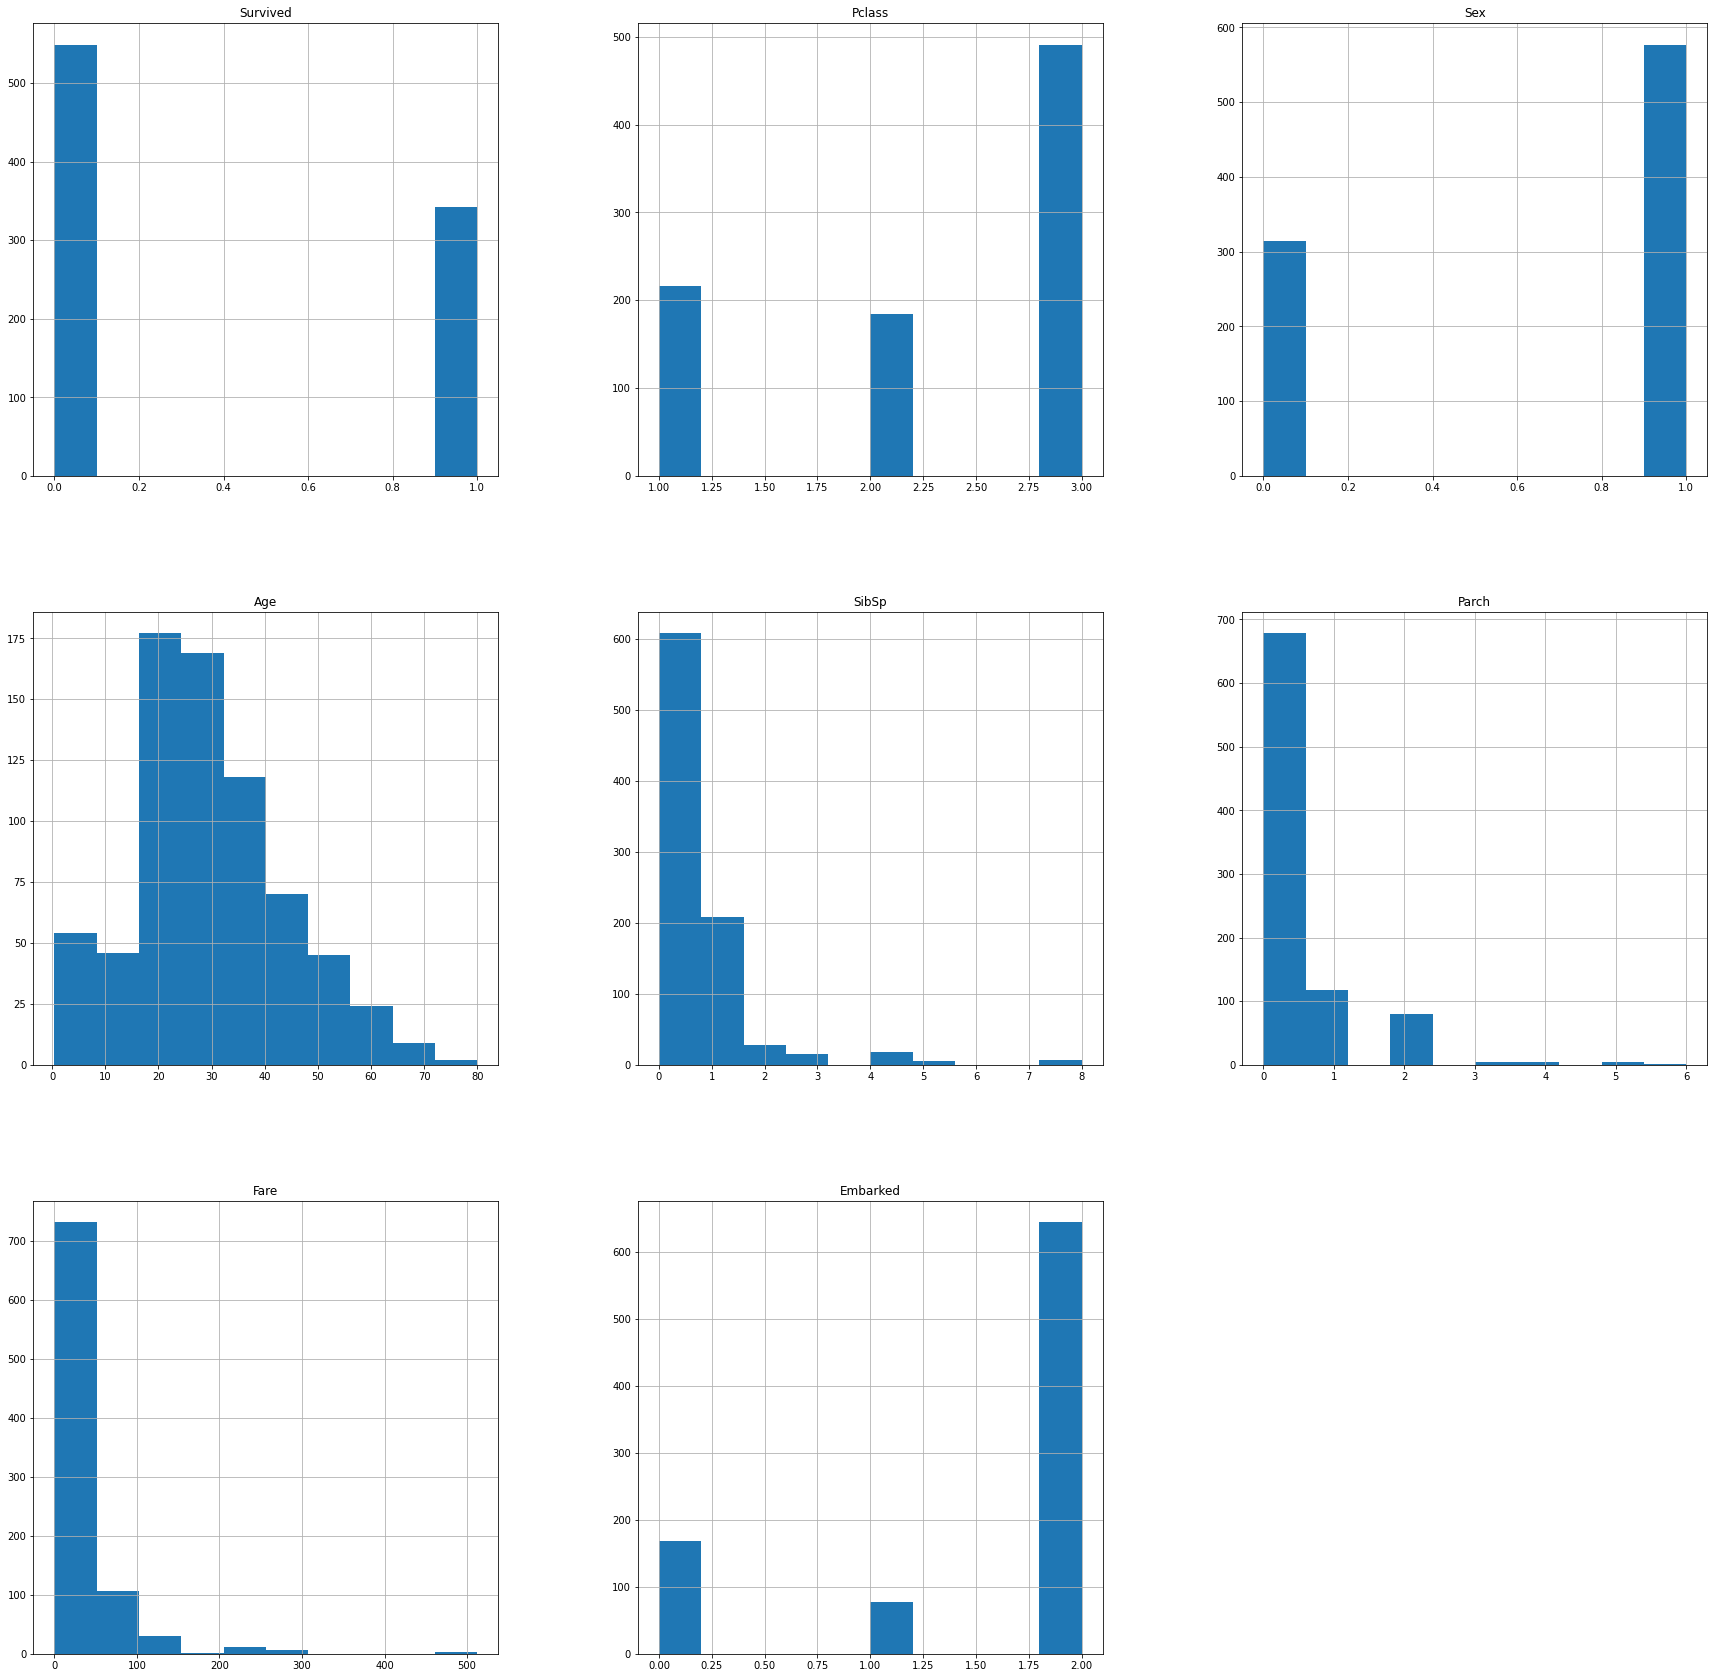

In [11]:
data_train.hist(figsize=(30,30))

In [12]:
cols_missing_train=[cols for cols in data_train.columns if
              data_train[cols].isnull().any()]
cols_missing_valid=[cols for cols in data_valid_copy.columns if
              data_valid[cols].isnull().any()]
cols_missing_train,cols_missing_valid

(['Age', 'Embarked'], ['Age', 'Fare'])

Since **'Age'** is missing values and it is not higly correlated with the target, we can procceed by dropping it

In [13]:
data_train.drop(["Age"],axis=1,inplace=True)
data_valid_copy.drop(["Age"],axis=1,inplace=True)

In [14]:
from sklearn.impute import SimpleImputer
impu=SimpleImputer()
data_valid_copy=impu.fit_transform(data_valid_copy)
data_train.fillna(0,inplace=True)

In [15]:
from sklearn.model_selection import train_test_split
y=data_train.Survived
X=data_train.drop(['Survived'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y)
X_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked
322,2,0.0,0,0,12.3500,1.0
718,3,1.0,0,0,15.5000,1.0
876,3,1.0,0,0,9.8458,2.0
649,3,0.0,0,0,7.5500,2.0
97,1,1.0,0,1,63.3583,0.0


In [16]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)
prdns=model.predict(X_test)

In [17]:
from sklearn.metrics import log_loss,mean_squared_error
loss=log_loss(y_test,prdns)
mse=mean_squared_error(y_test,prdns)
loss,mse

(7.589309575332859, 0.21973094170403587)

In [18]:
predictions=model.predict(data_valid_copy)
output = pd.DataFrame({'PassengerId': data_valid.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
